In [108]:
pip install pandas numpy scikit-learn matplotlib seaborn xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
from flask import Flask, request, jsonify

In [4]:
# Load datasets
pesticides_df = pd.read_csv('pesticides.csv')
rainfall_df = pd.read_csv('rainfall.csv')
temp_df = pd.read_csv('temp.csv')
yield_df = pd.read_csv('yield.csv')

In [5]:
print(pesticides_df.head())
print(rainfall_df.head())
print(temp_df.head())
print(yield_df.head())

           Domain     Area Element                Item  Year  \
0  Pesticides Use  Albania     Use  Pesticides (total)  1990   
1  Pesticides Use  Albania     Use  Pesticides (total)  1991   
2  Pesticides Use  Albania     Use  Pesticides (total)  1992   
3  Pesticides Use  Albania     Use  Pesticides (total)  1993   
4  Pesticides Use  Albania     Use  Pesticides (total)  1994   

                           Unit  Value  
0  tonnes of active ingredients  121.0  
1  tonnes of active ingredients  121.0  
2  tonnes of active ingredients  121.0  
3  tonnes of active ingredients  121.0  
4  tonnes of active ingredients  201.0  
          Area  Year Rainfall
0  Afghanistan  1985      327
1  Afghanistan  1986      327
2  Afghanistan  1987      327
3  Afghanistan  1989      327
4  Afghanistan  1990      327
   Year           Area  avg_temp
0  1849  Côte D'Ivoire     25.58
1  1850  Côte D'Ivoire     25.52
2  1851  Côte D'Ivoire     25.67
3  1852  Côte D'Ivoire       NaN
4  1853  Côte D'Ivoire  

In [6]:
# Rename columns for consistency
rainfall_df.rename(columns={' Area': 'Country', 'average_rain_fall_mm_per_year': 'Rainfall'}, inplace=True)
temp_df.rename(columns={'Area': 'Country', 'year': 'Year', 'avg_temp': 'Temperature'}, inplace=True)
pesticides_df.rename(columns={'Area': 'Country', 'Year': 'Year', 'Value': 'Pesticides'}, inplace=True)
yield_df.rename(columns={'Area': 'Country', 'Year': 'Year', 'Item': 'Crop', 'Value': 'Yield'}, inplace=True)

In [7]:
# Convert columns to numeric
rainfall_df['Year'] = rainfall_df['Year'].astype(int)
temp_df['Year'] = temp_df['Year'].astype(int)
pesticides_df['Year'] = pesticides_df['Year'].astype(int)
yield_df['Year'] = yield_df['Year'].astype(int)

In [8]:
# Merge datasets
merged_df = yield_df.merge(rainfall_df, on=['Country', 'Year'], how='left')
merged_df = merged_df.merge(temp_df, on=['Country', 'Year'], how='left')
merged_df = merged_df.merge(pesticides_df[['Country', 'Year', 'Pesticides']], on=['Country', 'Year'], how='left')

In [9]:
# Handle missing values
merged_df['Rainfall'] = pd.to_numeric(merged_df['Rainfall'], errors='coerce')
merged_df['Rainfall'].fillna(merged_df.groupby('Country')['Rainfall'].transform('mean'), inplace=True)
merged_df['Temperature'].fillna(merged_df.groupby('Country')['Temperature'].transform('mean'), inplace=True)
merged_df['Pesticides'].fillna(0, inplace=True)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_17928\2642628966.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['Rainfall'].fillna(merged_df.groupby('Country')['Rainfall'].transform('mean'), inplace=True)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_17928\2642628966.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which 

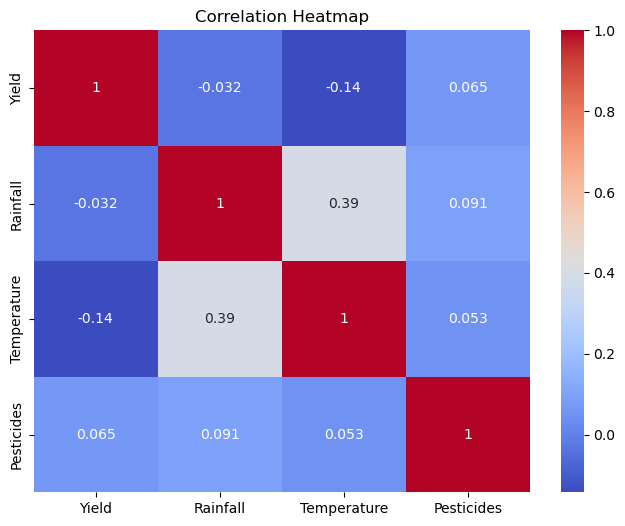

In [10]:
# Visualization: Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(merged_df[['Yield', 'Rainfall', 'Temperature', 'Pesticides']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

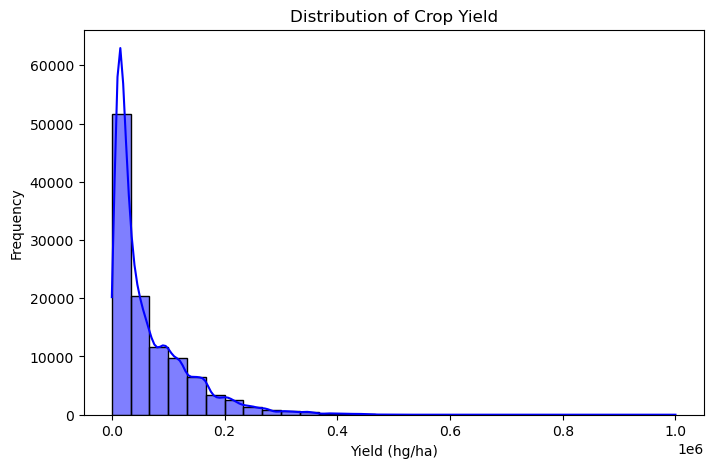

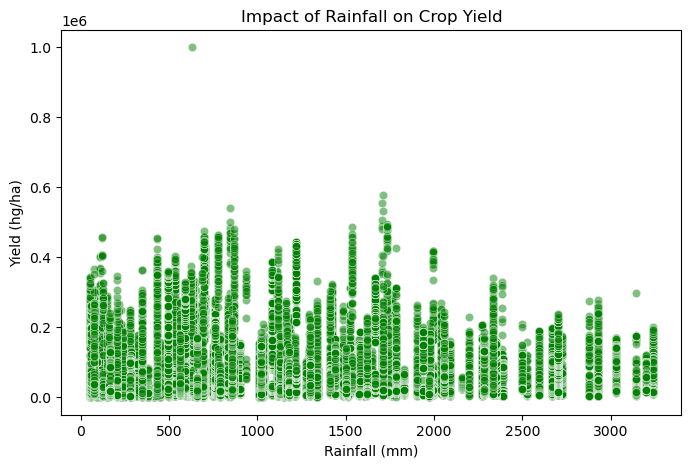

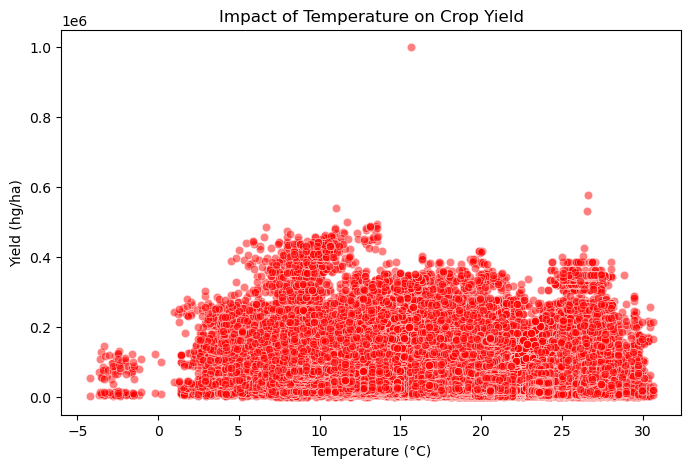

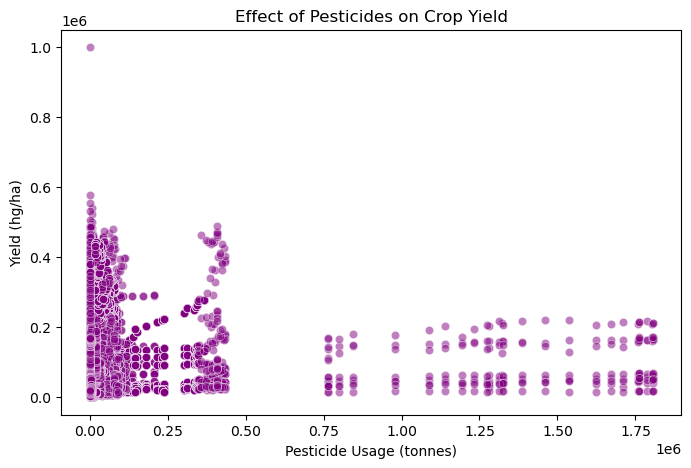

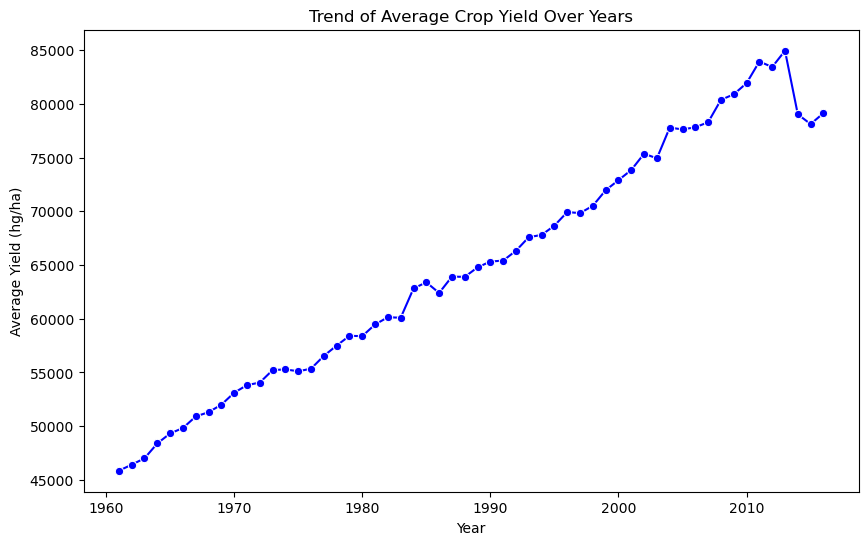

In [11]:
# Yield Distribution
plt.figure(figsize=(8, 5))
sns.histplot(merged_df['Yield'], bins=30, kde=True, color='blue')
plt.xlabel("Yield (hg/ha)")
plt.ylabel("Frequency")
plt.title("Distribution of Crop Yield")
plt.show()

# Scatter plot: Yield vs Rainfall
plt.figure(figsize=(8, 5))
sns.scatterplot(x=merged_df['Rainfall'], y=merged_df['Yield'], alpha=0.5, color='green')
plt.xlabel("Rainfall (mm)")
plt.ylabel("Yield (hg/ha)")
plt.title("Impact of Rainfall on Crop Yield")
plt.show()

# Scatter plot: Yield vs Temperature
plt.figure(figsize=(8, 5))
sns.scatterplot(x=merged_df['Temperature'], y=merged_df['Yield'], alpha=0.5, color='red')
plt.xlabel("Temperature (°C)")
plt.ylabel("Yield (hg/ha)")
plt.title("Impact of Temperature on Crop Yield")
plt.show()

# Scatter plot: Yield vs Pesticides
plt.figure(figsize=(8, 5))
sns.scatterplot(x=merged_df['Pesticides'], y=merged_df['Yield'], alpha=0.5, color='purple')
plt.xlabel("Pesticide Usage (tonnes)")
plt.ylabel("Yield (hg/ha)")
plt.title("Effect of Pesticides on Crop Yield")
plt.show()

# Line plot: Average Yield over Years
avg_yield_per_year = merged_df.groupby('Year')['Yield'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='Year', y='Yield', data=avg_yield_per_year, marker='o', color='blue')
plt.xlabel("Year")
plt.ylabel("Average Yield (hg/ha)")
plt.title("Trend of Average Crop Yield Over Years")
plt.show()

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
# Create Country encoder
country_encoder = LabelEncoder()
country_encoder.fit(merged_df['Country'])

LabelEncoder()

In [14]:
# Create Crop encoder
crop_encoder = LabelEncoder()
crop_encoder.fit(merged_df['Crop'])

LabelEncoder()

In [15]:
# Save both encoders
joblib.dump(country_encoder, 'country_label_encoder.pkl')
joblib.dump(crop_encoder, 'crop_label_encoder.pkl')

['crop_label_encoder.pkl']

In [16]:
print("Countries:", country_encoder.classes_)
print("Crops:", crop_encoder.classes_)

Countries: ['Afghanistan' 'Albania' 'Algeria' 'American Samoa' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Belgium-Luxembourg' 'Belize' 'Benin' 'Bermuda' 'Bhutan'
 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina' 'Botswana'
 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada' 'Cayman Islands'
 'Central African Republic' 'Chad' 'Chile' 'China' 'China, Hong Kong SAR'
 'China, Taiwan Province of' 'China, mainland' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 'Czechoslovakia' "Côte d'Ivoire" "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Ethiopia PDR' 'Faroe Islands'
 'Fiji' 'Finland' 'F

In [17]:
# Encode 'Country' and 'Crop' columns
country_encoder = LabelEncoder()
crop_encoder = LabelEncoder()

merged_df['Country'] = country_encoder.fit_transform(merged_df['Country'])
merged_df['Crop'] = crop_encoder.fit_transform(merged_df['Crop'])

In [18]:
# Prepare features and target
features = ['Country', 'Temperature', 'Rainfall', 'Year', 'Pesticides', 'Crop']
target = 'Yield'

X = merged_df[features]
y = merged_df[target]

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Train
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluate
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_r2 = r2_score(y_test, y_pred)

print(f"Best XGBoost Model RMSE: {xgb_rmse:.2f}")
print(f"Best XGBoost Model R² Score: {xgb_r2:.2f}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost Model RMSE: 16909.36
Best XGBoost Model R² Score: 0.94


In [ ]:
rf_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=5, 
    cv=2,      
    verbose=1,
    random_state=42,
    n_jobs=-1
)


# Train
rf_random_search.fit(X_train, y_train)
rf_model = rf_random_search.best_estimator_
rf_model.fit(X_train, y_train)

# Predict
rf_preds = rf_model.predict(X_test)

# Evaluate
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
rf_r2 = r2_score(y_test, rf_preds)

print("Random Forest RMSE:", rf_rmse)
print("Random Forest R^2:", rf_r2)


Fitting 2 folds for each of 5 candidates, totalling 10 fits
Random Forest RMSE: 15868.024398173311
Random Forest R^2: 0.9484391369090192


c:\Users\lenovo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


           Model          RMSE       R^2
0        XGBoost  16909.356884  0.941450
1  Random Forest  15868.024398  0.948439


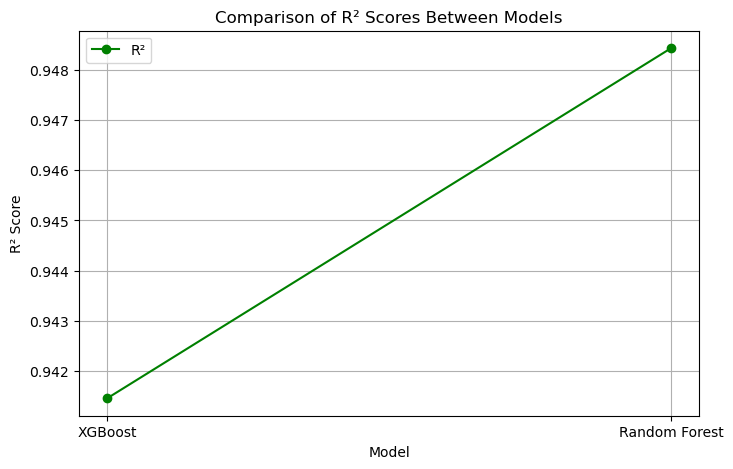

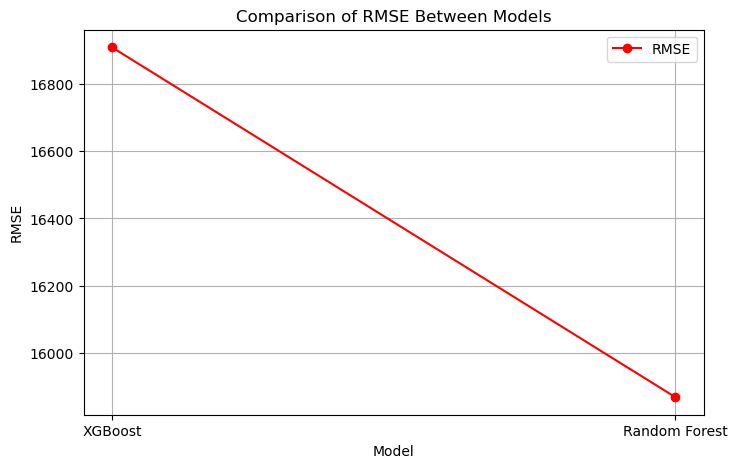

In [61]:
import pandas as pd
comparison_df = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest'],
    'RMSE': [xgb_rmse, rf_rmse],
    'R^2': [xgb_r2, rf_r2]
})
print(comparison_df)

# Line graph comparing R²
plt.figure(figsize=(8, 5))

# Plot R²
plt.plot(comparison_df['Model'], comparison_df['R^2'], marker='o', label='R²', color='green')

plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Comparison of R² Scores Between Models')
plt.legend()
plt.grid(True)
plt.show()

# Line graph comparing RMSE
plt.figure(figsize=(8, 5))
plt.plot(comparison_df['Model'], comparison_df['RMSE'], marker='o', label='RMSE', color='red')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE Between Models')
plt.legend()
plt.grid(True)
plt.show()




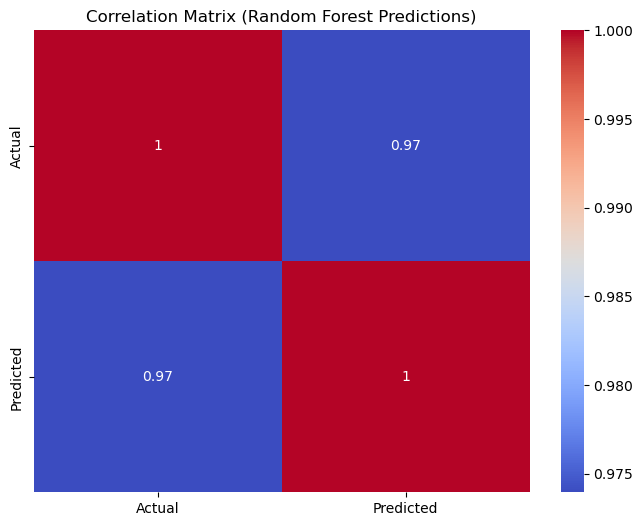

In [59]:
# Calculate and visualize the correlation matrix for Random Forest predictions
rf_results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': rf_preds
})

correlation_matrix_rf = rf_results_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_rf, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Random Forest Predictions)')
plt.savefig('random_forest_correlation_matrix.png')
plt.show()

In [60]:
# Save model
joblib.dump(rf_model, 'random_forest_yield_model.pkl')
joblib.dump(best_model, 'xgboost_yield_model.pkl')

['xgboost_yield_model.pkl']